<h1 style="color: blue; text-align: center">Malicious URLs Detection </h1>
<hr width: 5px>

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from extraction_functions import *

# Loading Data

In [2]:
data = pd.read_csv("dataset.csv")

In [3]:
data.head(10)

,url,label
0,br-icloud.com.br,malicious
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,malicious
4,http://adventure-nicaragua.net/index.php?optio...,malicious
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,malicious
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [4]:
data.shape

(651203, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651203 entries, 0 to 651202
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651203 non-null  object
 1   label   651203 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [6]:
data.isnull().sum()

url      0
label    0
dtype: int64

# Checking duplicate URLs

In [7]:
duplicate_urls = data[data.duplicated(subset=['url'], keep=False)]
len(duplicate_urls)

12279

Remove duplicates with the same label, keeping one instance:

In [8]:
data = data.drop_duplicates(subset=['url', 'label'], keep='first')

Now we only have duplicates with different labels , so we will remove both instances:

In [9]:
duplicate_urls = data[data.duplicated(subset=['url'], keep=False)]

indices_to_drop = duplicate_urls.index

data = data.drop(indices_to_drop)

In [10]:
data.shape

(641125, 2)

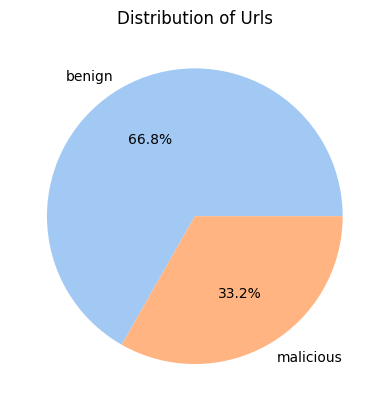

In [11]:
plt.figure()
plt.pie(data['label'].value_counts(), labels=data['label'].value_counts().index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('Distribution of Urls')
plt.show()

# Feature Extraction

In this step we will be extracting features from the URLs such as URL length , number of characters and special characters (“//” , “.”, “@”) , HTTPS presence...,
These features will help us in the model training.

In [12]:
data.head()

,url,label
0,br-icloud.com.br,malicious
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,malicious
4,http://adventure-nicaragua.net/index.php?optio...,malicious


Extracting the lenth of the URLs

In [13]:
data["url_len"] = data["url"].apply(len)

In [14]:
data.head()

,url,label,url_len
0,br-icloud.com.br,malicious,16
1,mp3raid.com/music/krizz_kaliko.html,benign,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,31
3,http://www.garage-pirenne.be/index.php?option=...,malicious,88
4,http://adventure-nicaragua.net/index.php?optio...,malicious,235


Extracting the numbre of special characters in the URLs

In [15]:
data['num_special_chars'] = data['url'].apply(lambda x: count_special_characters(x))

In [16]:
data.head()

,url,label,url_len,num_special_chars
0,br-icloud.com.br,malicious,16,3
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,2
3,http://www.garage-pirenne.be/index.php?option=...,malicious,88,10
4,http://adventure-nicaragua.net/index.php?optio...,malicious,235,8


The hostname of a URL is the part of the URL that identifies the domain or server where the resource is located. It typically includes the domain name and may include subdomains. For example:

For the URL "https://www.example.com/subpage", the hostname is "www.example.com".
For the URL "https://subdomain.example.com/page", the hostname is "subdomain.example.com".

the function 'hostname_length' returns the length of the hostname.

In [17]:
data['hostname_length'] = data['url'].apply(lambda i: hostname_length(i))

Add a new 'Abnormal_URL' column, the function 'abnormal_url' checks if the hostname extracted from the URL matches any part of the URL itself. If a match is found, it returns 1 indicating that the URL is abnormal, otherwise, it returns 0.

In [18]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

In [19]:
data['abnormal_url'].value_counts()

abnormal_url
0    463151
1    177974
Name: count, dtype: int64

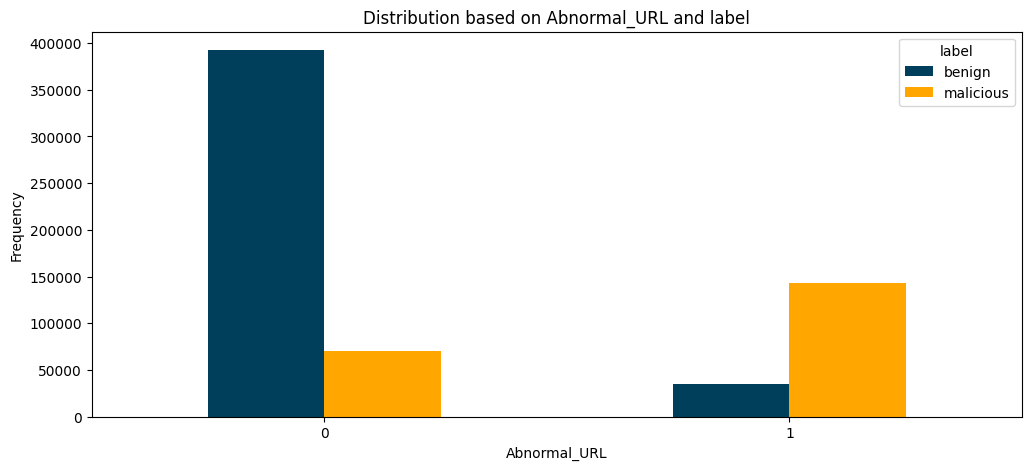

In [20]:
pd.crosstab(data["abnormal_url"], data["label"]).plot(kind="bar",figsize=(12,5),color=['#003f5c','#ffa600','#bc5090','#ff6361'])
plt.title('Distribution based on Abnormal_URL and label')
plt.xlabel('Abnormal_URL')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(title="label")
plt.show()

In [21]:
data.head()

,url,label,url_len,num_special_chars,hostname_length,abnormal_url
0,br-icloud.com.br,malicious,16,3,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,2,0,0
3,http://www.garage-pirenne.be/index.php?option=...,malicious,88,10,21,1
4,http://adventure-nicaragua.net/index.php?optio...,malicious,235,8,23,1


Counting the number of appearances of 'https', 'http', and 'www' in the URL.

In [22]:
data['count-https'] = data['url'].apply(lambda i : count_https(i))

data['count-http'] = data['url'].apply(lambda i : count_http(i))

data['count-www'] = data['url'].apply(lambda i: count_www(i))

In [23]:
data.head()

,url,label,url_len,num_special_chars,hostname_length,abnormal_url,count-https,count-http,count-www
0,br-icloud.com.br,malicious,16,3,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,2,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,malicious,88,10,21,1,0,1,1
4,http://adventure-nicaragua.net/index.php?optio...,malicious,235,8,23,1,0,1,0


Counting the number of digits and letters in the URL

In [24]:
data['digit_count'] = data['url'].apply(lambda x: sum(c.isdigit() for c in x))

data['letter_count'] = data['url'].apply(lambda x: sum(c.isalpha() for c in x))

In [25]:
data.head()

,url,label,url_len,num_special_chars,hostname_length,abnormal_url,count-https,count-http,count-www,digit_count,letter_count
0,br-icloud.com.br,malicious,16,3,0,0,0,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,0,0,0,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,2,0,0,0,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,malicious,88,10,21,1,0,1,1,7,63
4,http://adventure-nicaragua.net/index.php?optio...,malicious,235,8,23,1,0,1,0,22,199


The presence of IP addresses: Phishing and malicious URLs often use IP addresses instead of domain names to hide their true identity or to bypass domain blacklisting mechanisms. Detecting the presence of IP addresses in URLs might be informative for classification.

In [26]:
data['use_of_ip'] = data['url'].apply(lambda i: having_ip_address(i))

In [27]:
data.head()

,url,label,url_len,num_special_chars,hostname_length,abnormal_url,count-https,count-http,count-www,digit_count,letter_count,use_of_ip
0,br-icloud.com.br,malicious,16,3,0,0,0,0,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,0,0,0,0,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,2,0,0,0,0,0,1,25,0
3,http://www.garage-pirenne.be/index.php?option=...,malicious,88,10,21,1,0,1,1,7,63,0
4,http://adventure-nicaragua.net/index.php?optio...,malicious,235,8,23,1,0,1,0,22,199,0


In [28]:
data['use_of_ip'].value_counts()

use_of_ip
0    633833
1      7292
Name: count, dtype: int64

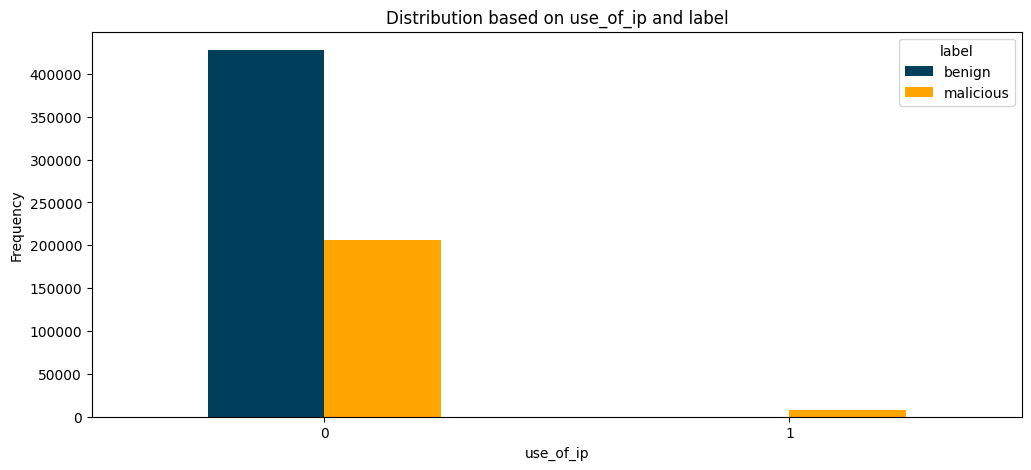

In [29]:
pd.crosstab(data["use_of_ip"], data["label"]).plot(kind="bar",figsize=(12,5),color=['#003f5c','#ffa600','#bc5090','#ff6361'])
plt.title('Distribution based on use_of_ip and label')
plt.xlabel('use_of_ip')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(title="label")
plt.show()

Detecting the usage of URL shortening services: URL shortening services are online tools or services that take a long URL and generate a shorter, more compact version. These shortened URLs redirect users to the original, longer URL when clicked. They are commonly used to make long URLs more manageable, shareable, and easier to distribute, particularly on platforms like social media where character limits may apply.

Examples of popular URL shortening services include Bitly (bit.ly), Google URL Shortener (goo.gl, now deprecated), TinyURL (tinyurl.com), and others

In [30]:
data['has_Shortening_Service'] = data['url'].apply(has_shortening_service)

In [31]:
data.head()

,url,label,url_len,num_special_chars,hostname_length,abnormal_url,count-https,count-http,count-www,digit_count,letter_count,use_of_ip,has_Shortening_Service
0,br-icloud.com.br,malicious,16,3,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,2,0,0,0,0,0,1,25,0,0
3,http://www.garage-pirenne.be/index.php?option=...,malicious,88,10,21,1,0,1,1,7,63,0,0
4,http://adventure-nicaragua.net/index.php?optio...,malicious,235,8,23,1,0,1,0,22,199,0,0


In [32]:
data['has_Shortening_Service'].value_counts()

has_Shortening_Service
0    601707
1     39418
Name: count, dtype: int64

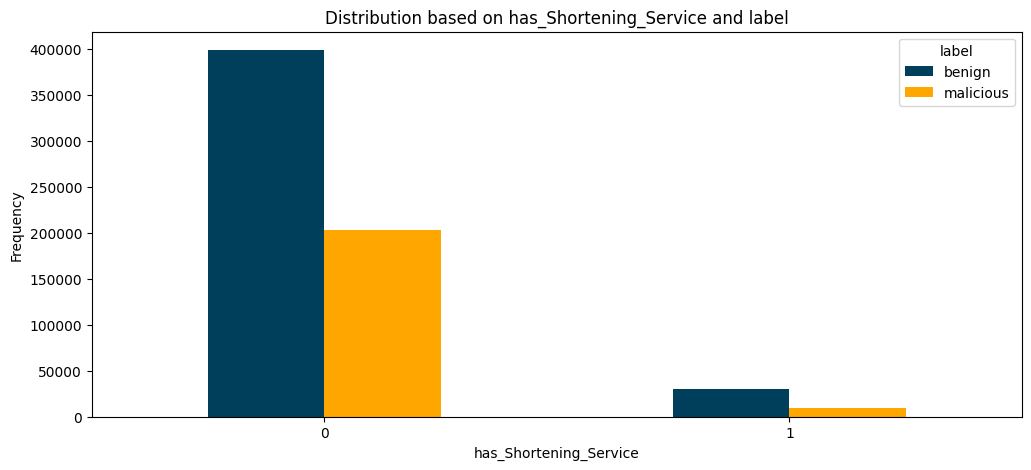

In [33]:
pd.crosstab(data["has_Shortening_Service"], data["label"]).plot(kind="bar",figsize=(12,5),color=['#003f5c','#ffa600','#bc5090','#ff6361'])
plt.title('Distribution based on has_Shortening_Service and label')
plt.xlabel('has_Shortening_Service')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(title="label")
plt.show()

Detecting JavaScript code within URLs can be informative for identifying certain types of malicious or suspicious URLs. Malicious actors may include JavaScript code in URLs for various purposes, such as redirecting users to malicious websites, executing unauthorized actions in the browser, or exploiting vulnerabilities.

In [34]:
data['has_javascript_Code'] = data['url'].apply(has_javascript_Code)

In [35]:
data.head()

,url,label,url_len,num_special_chars,hostname_length,abnormal_url,count-https,count-http,count-www,digit_count,letter_count,use_of_ip,has_Shortening_Service,has_javascript_Code
0,br-icloud.com.br,malicious,16,3,0,0,0,0,0,0,13,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,0,0,0,0,0,1,29,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,2,0,0,0,0,0,1,25,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,malicious,88,10,21,1,0,1,1,7,63,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,malicious,235,8,23,1,0,1,0,22,199,0,0,1


In [36]:
data['has_javascript_Code'].value_counts()

has_javascript_Code
0    595734
1     45391
Name: count, dtype: int64

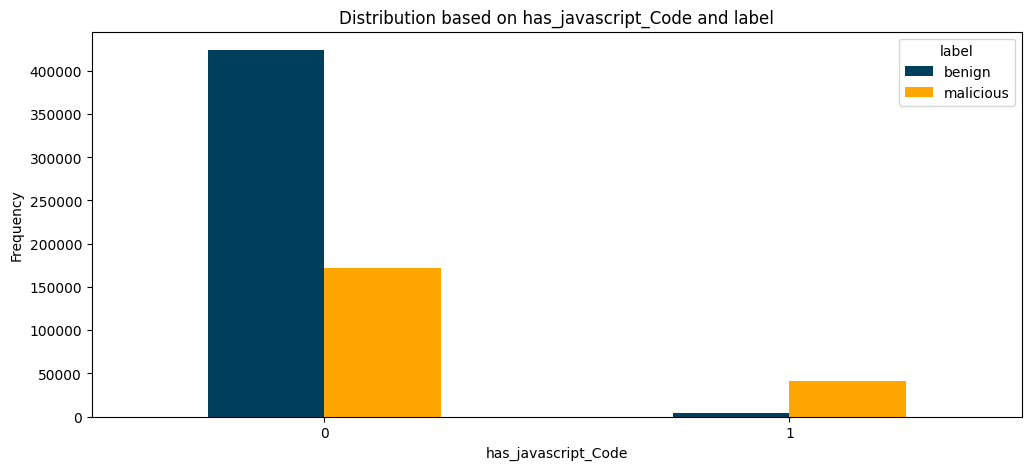

In [37]:
pd.crosstab(data["has_javascript_Code"], data["label"]).plot(kind="bar",figsize=(12,5),color=['#003f5c','#ffa600','#bc5090','#ff6361'])
plt.title('Distribution based on has_javascript_Code and label')
plt.xlabel('has_javascript_Code')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(title="label")
plt.show()

Detecting text encoding in URLs can be useful for identifying attempts to obfuscate or hide malicious content within URLs. Malicious actors may encode URLs using various text encoding schemes to evade detection or bypass security measures.

In [38]:
data['has_Text_Encoding'] = data['url'].apply(check_text_encoding)

In [39]:
data['has_Text_Encoding'].value_counts()

has_Text_Encoding
0    628549
1     12576
Name: count, dtype: int64

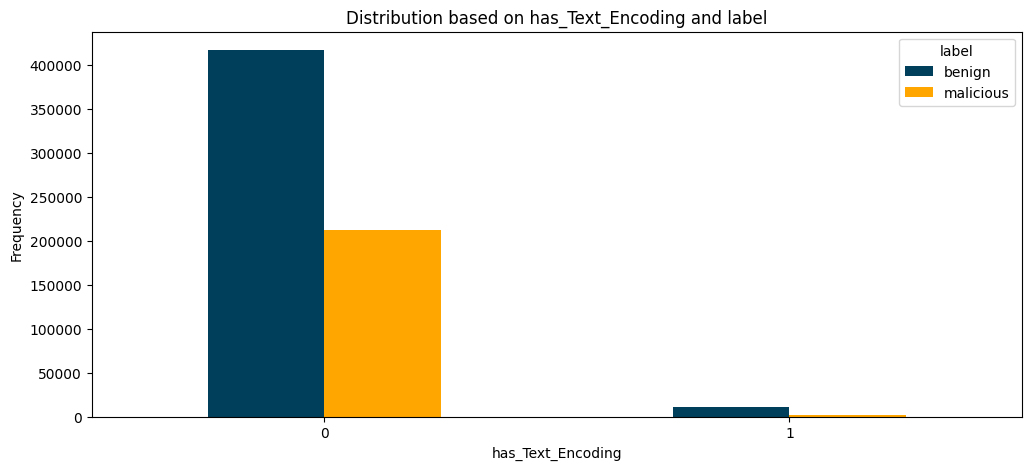

In [40]:
pd.crosstab(data["has_Text_Encoding"], data["label"]).plot(kind="bar",figsize=(12,5),color=['#003f5c','#ffa600','#bc5090','#ff6361'])
plt.title('Distribution based on has_Text_Encoding and label')
plt.xlabel('has_Text_Encoding')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(title="label")
plt.show()

In [41]:
data.head(10)

,url,label,url_len,num_special_chars,hostname_length,abnormal_url,count-https,count-http,count-www,digit_count,letter_count,use_of_ip,has_Shortening_Service,has_javascript_Code,has_Text_Encoding
0,br-icloud.com.br,malicious,16,3,0,0,0,0,0,0,13,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,0,0,0,0,0,1,29,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,2,0,0,0,0,0,1,25,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,malicious,88,10,21,1,0,1,1,7,63,0,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,malicious,235,8,23,1,0,1,0,22,199,0,0,1,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,118,19,11,1,0,1,0,1,93,0,0,0,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,45,3,0,0,0,0,0,4,31,0,0,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,46,5,0,0,0,0,0,0,40,0,1,0,0
8,http://www.pashminaonline.com/pure-pashminas,malicious,44,4,22,1,0,1,1,0,37,0,0,0,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,45,5,0,0,0,0,0,5,33,0,0,0,0


We will change the values of "label" into numeric

In [42]:
label_mapping = {"benign": 0, "malicious": 1}
data['label'] = data['label'].map(label_mapping)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 641125 entries, 0 to 651202
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   url                     641125 non-null  object
 1   label                   641125 non-null  int64 
 2   url_len                 641125 non-null  int64 
 3   num_special_chars       641125 non-null  int64 
 4   hostname_length         641125 non-null  int64 
 5   abnormal_url            641125 non-null  int64 
 6   count-https             641125 non-null  int64 
 7   count-http              641125 non-null  int64 
 8   count-www               641125 non-null  int64 
 9   digit_count             641125 non-null  int64 
 10  letter_count            641125 non-null  int64 
 11  use_of_ip               641125 non-null  int64 
 12  has_Shortening_Service  641125 non-null  int64 
 13  has_javascript_Code     641125 non-null  int64 
 14  has_Text_Encoding       641125 non-null  

In [44]:
data.isnull().sum()

url                       0
label                     0
url_len                   0
num_special_chars         0
hostname_length           0
abnormal_url              0
count-https               0
count-http                0
count-www                 0
digit_count               0
letter_count              0
use_of_ip                 0
has_Shortening_Service    0
has_javascript_Code       0
has_Text_Encoding         0
dtype: int64

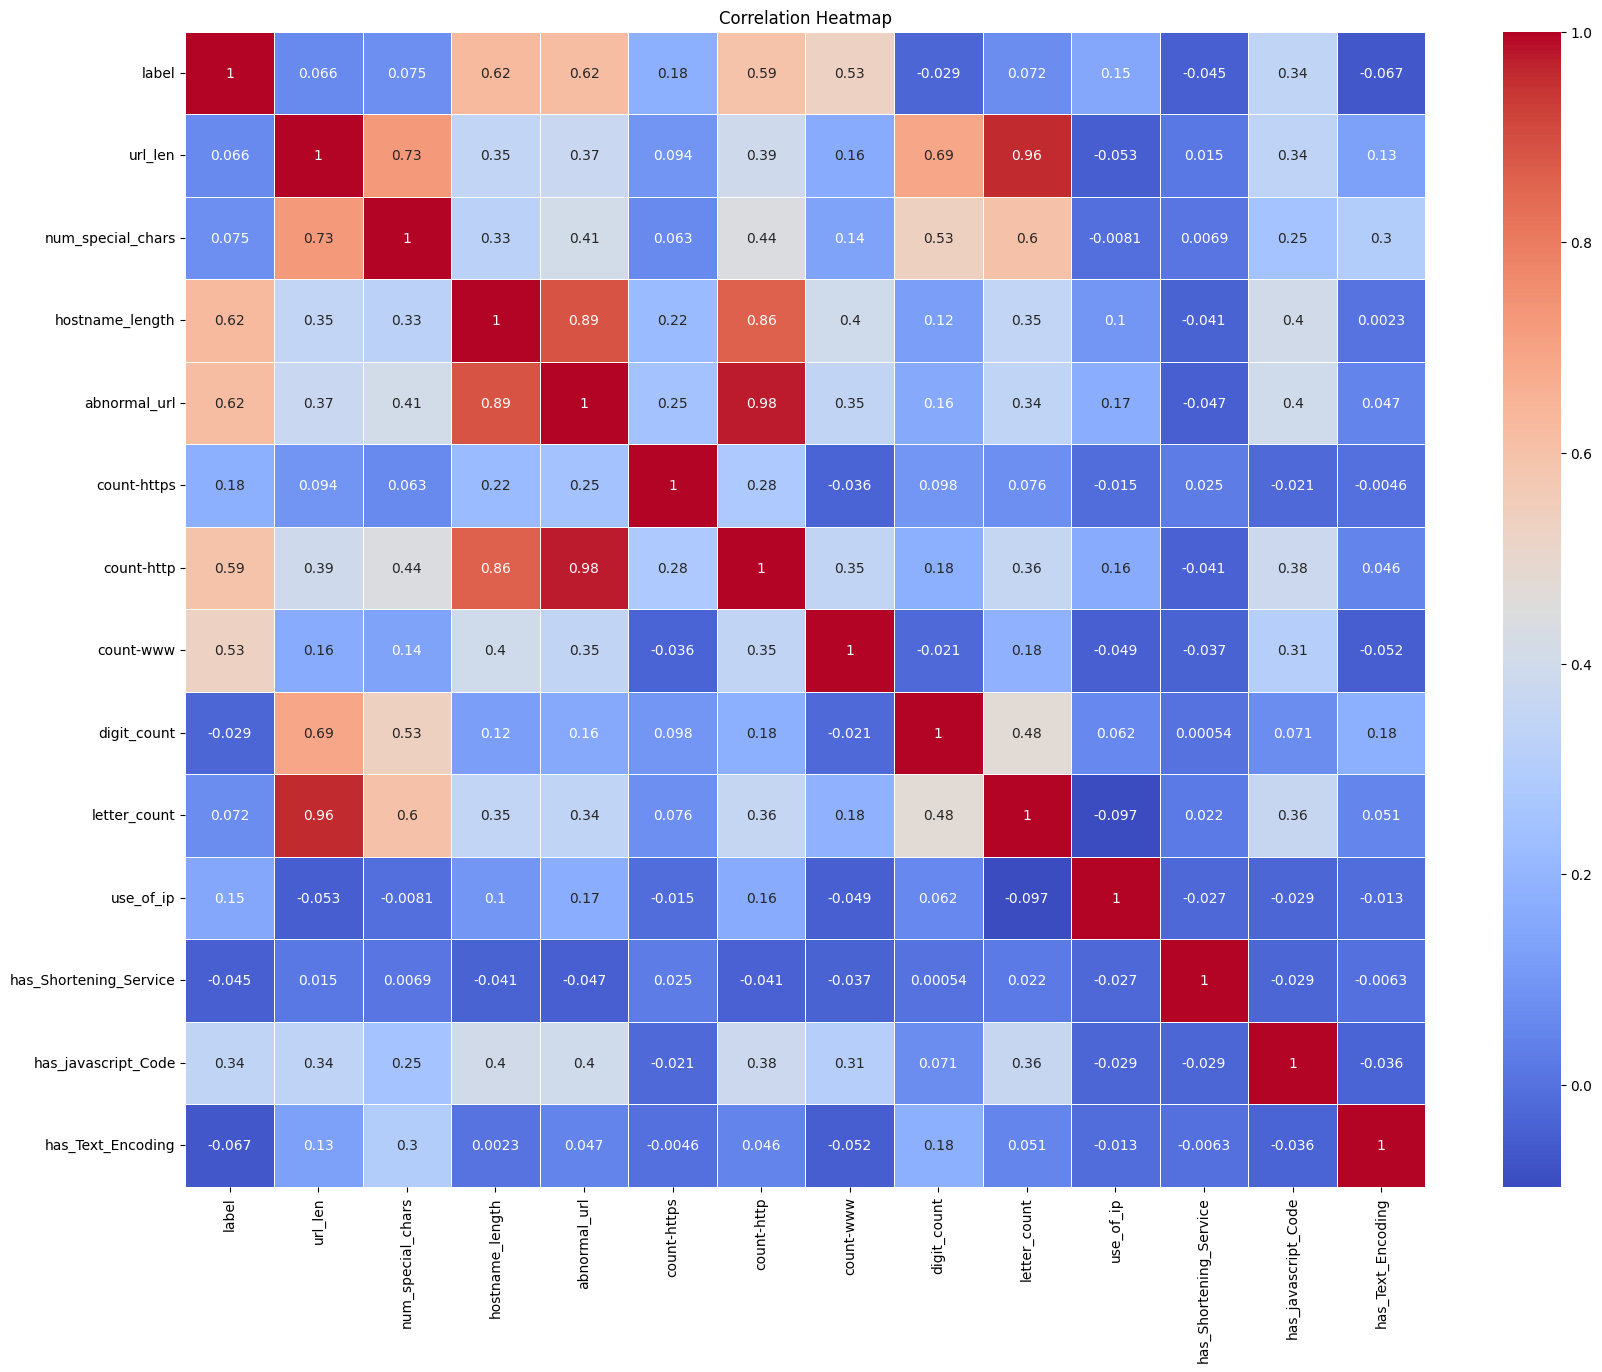

In [45]:
correlation_matrix = data.drop(columns=['url']).corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 641125 entries, 0 to 651202
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   url                     641125 non-null  object
 1   label                   641125 non-null  int64 
 2   url_len                 641125 non-null  int64 
 3   num_special_chars       641125 non-null  int64 
 4   hostname_length         641125 non-null  int64 
 5   abnormal_url            641125 non-null  int64 
 6   count-https             641125 non-null  int64 
 7   count-http              641125 non-null  int64 
 8   count-www               641125 non-null  int64 
 9   digit_count             641125 non-null  int64 
 10  letter_count            641125 non-null  int64 
 11  use_of_ip               641125 non-null  int64 
 12  has_Shortening_Service  641125 non-null  int64 
 13  has_javascript_Code     641125 non-null  int64 
 14  has_Text_Encoding       641125 non-null  

# Training Models

In [47]:
X = data.drop(columns=['url', 'label'])
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,shuffle=True, random_state=5)

<h4>Logistic Regression</>

              precision    recall  f1-score   support

      benign       0.90      0.96      0.93     85712
   malicious       0.91      0.78      0.84     42513

    accuracy                           0.90    128225
   macro avg       0.90      0.87      0.88    128225
weighted avg       0.90      0.90      0.90    128225

Accuracy: 90.03


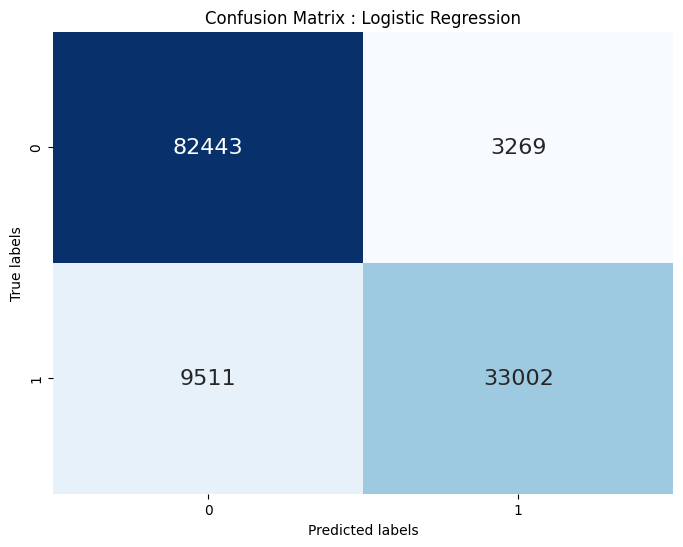

In [48]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

print(classification_report(y_test, y_pred_logreg, target_names=['benign', 'malicious']))

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Accuracy: {:.2f}".format(accuracy_logreg * 100))

cm = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix : Logistic Regression')
plt.show()

<h4>KNeighbors Classifier</>

              precision    recall  f1-score   support

      benign       0.94      0.98      0.96     85712
   malicious       0.96      0.87      0.92     42513

    accuracy                           0.95    128225
   macro avg       0.95      0.93      0.94    128225
weighted avg       0.95      0.95      0.95    128225

Accuracy: 94.64


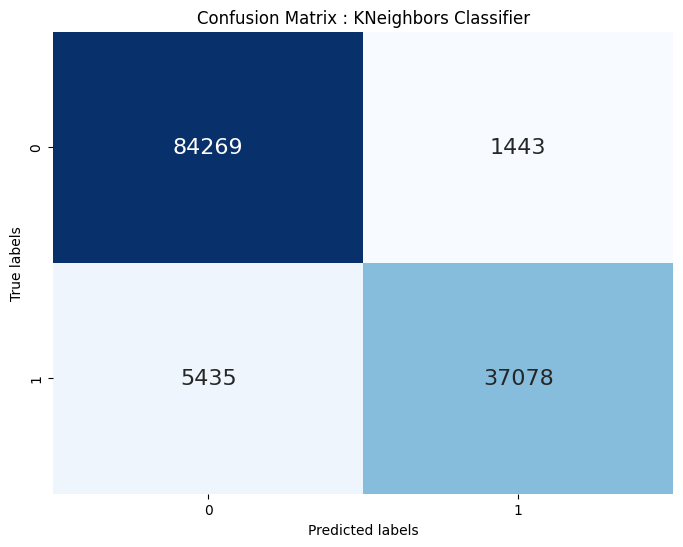

In [49]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print(classification_report(y_test,y_pred_knn,target_names=['benign', 'malicious']))

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy: {:.2f}".format(accuracy_knn*100))

cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix : KNeighbors Classifier')
plt.show()

<h4>Decision Tree Classifier</>

              precision    recall  f1-score   support

      benign       0.96      0.98      0.97     85712
   malicious       0.96      0.92      0.94     42513

    accuracy                           0.96    128225
   macro avg       0.96      0.95      0.95    128225
weighted avg       0.96      0.96      0.96    128225

Accuracy: 95.93


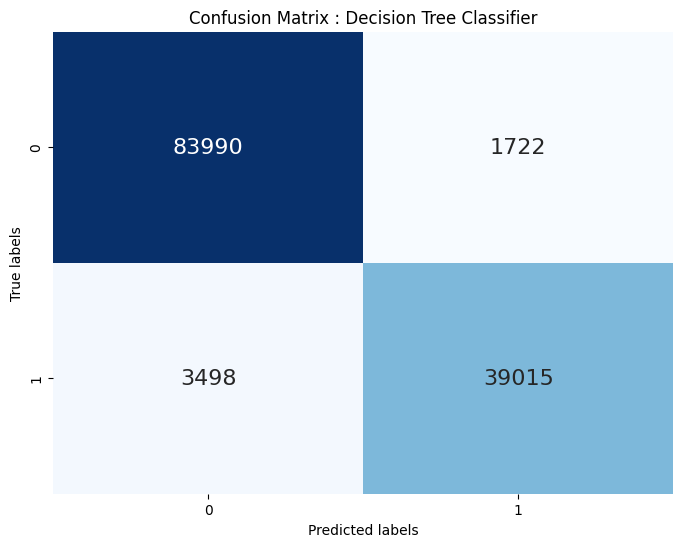

In [50]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print(classification_report(y_test, y_pred_dt, target_names=['benign', 'malicious']))

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy: {:.2f}".format(accuracy_dt * 100))

cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix : Decision Tree Classifier')
plt.show()

<h4>Random Forest Classifier</>

              precision    recall  f1-score   support

      benign       0.96      0.98      0.97     85712
   malicious       0.96      0.92      0.94     42513

    accuracy                           0.96    128225
   macro avg       0.96      0.95      0.96    128225
weighted avg       0.96      0.96      0.96    128225

Accuracy: 96.20


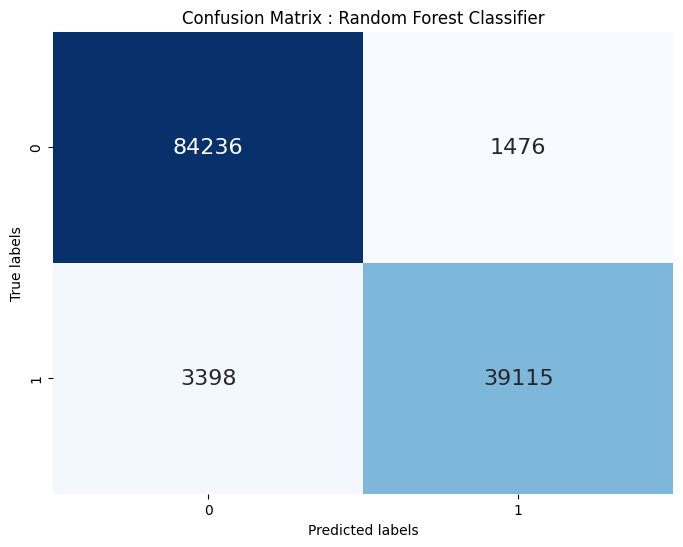

In [51]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print(classification_report(y_test,y_pred_rf,target_names=['benign', 'malicious']))

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy: {:.2f}".format(accuracy_rf*100))

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix : Random Forest Classifier')
plt.show()

# Cross validation

<h4>Logistic Regression</>

In [ ]:
k_folds = 5 
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

cv_scores = cross_val_score(logreg, X, y, cv=kf, scoring='accuracy')
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

print("Logistic Regression:")
print("Mean Cross-Validation Score : ", mean_cv_score)
print("Standard Deviation of Cross-Validation Score:", std_cv_score)

Logistic Regression:
Mean Cross-Validation Score :  0.901116007018912
Standard Deviation of Cross-Validation Score: 0.0007185154606630997


<h4>KNN</>

In [ ]:
cv_scores = cross_val_score(knn, X, y, cv=kf, scoring='accuracy')
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

print("KNN:")
print("Mean Cross-Validation Score :", mean_cv_score)
print("Standard Deviation of Cross-Validation Score:", std_cv_score)

KNN:
Mean Cross-Validation Score : 0.9294396568531879
Standard Deviation of Cross-Validation Score: 0.001356223914029408


<h4>Decision Tree</>

In [ ]:
cv_scores = cross_val_score(dt, X, y, cv=kf, scoring='accuracy')
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()
print("Decision Tree:")
print("Mean Cross-Validation Score :", mean_cv_score)
print("Standard Deviation of Cross-Validation Score:", std_cv_score)

Decision Tree:
Mean Cross-Validation Score : 0.9604367323064926
Standard Deviation of Cross-Validation Score: 0.0004455833731433475


<h4>Random Forest</>

In [ ]:
cv_scores = cross_val_score(rf, X, y, cv=kf, scoring='accuracy')
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()
print("Random Forest :")
print("Mean Cross-Validation Score :", mean_cv_score)
print("Standard Deviation of Cross-Validation Score:", std_cv_score)

Random Forest :
Mean Cross-Validation Score : 0.963135114057321
Standard Deviation of Cross-Validation Score: 0.0002766098319511481


# Hyperparameter Tuning

<h4>Logistic Regression</>

In [ ]:
param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']}

grid_search_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid_logreg, cv=5, scoring='accuracy')

grid_search_logreg.fit(X_train, y_train)

best_params_logreg = grid_search_logreg.best_params_

print("Best Parameters for Logistic Regression:", best_params_logreg)

Best Parameters for Logistic Regression: {'C': 10, 'penalty': 'l2'}


In [ ]:
best_model_logreg = grid_search_logreg.best_estimator_

y_pred_logreg_tuned = best_model_logreg.predict(X_test)

print("Logistic Regression - After Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_logreg_tuned, target_names=['benign', 'malicious']))

Logistic Regression - After Hyperparameter Tuning:
              precision    recall  f1-score   support

      benign       0.90      0.96      0.93     85712
   malicious       0.91      0.78      0.84     42513

    accuracy                           0.90    128225
   macro avg       0.90      0.87      0.88    128225
weighted avg       0.90      0.90      0.90    128225



<h4>KNN</>

In [53]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 20, 30]}

grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='accuracy')

grid_search_knn.fit(X_train, y_train)

best_params_knn = grid_search_knn.best_params_

print("Best Parameters for k-Nearest Neighbors:", best_params_knn)

Best Parameters for k-Nearest Neighbors: {'n_neighbors': 5}


In [54]:
best_model_knn = grid_search_knn.best_estimator_

y_pred_knn_tuned = best_model_knn.predict(X_test)

print("K-Nearest Neighbors - After Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_knn_tuned, target_names=['benign', 'malicious']))


K-Nearest Neighbors - After Hyperparameter Tuning:
              precision    recall  f1-score   support

      benign       0.95      0.98      0.97     85712
   malicious       0.96      0.90      0.93     42513

    accuracy                           0.95    128225
   macro avg       0.95      0.94      0.95    128225
weighted avg       0.95      0.95      0.95    128225



<h4>Decision Tree</>

In [ ]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]}

grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, scoring='accuracy')

grid_search_dt.fit(X_train, y_train)

best_params_dt = grid_search_dt.best_params_

print("Best Parameters for Decision Tree:", best_params_dt)

Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}


In [ ]:
best_model_dt = grid_search_dt.best_estimator_

y_pred_dt_tuned = best_model_dt.predict(X_test)

print("Decision Tree - After Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_dt_tuned, target_names=['benign', 'malicious']))

Decision Tree - After Hyperparameter Tuning:
              precision    recall  f1-score   support

      benign       0.96      0.98      0.97     85712
   malicious       0.96      0.92      0.94     42513

    accuracy                           0.96    128225
   macro avg       0.96      0.95      0.95    128225
weighted avg       0.96      0.96      0.96    128225



<h4>Random Forest</>

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'max_leaf_nodes': [None, 3, 6]
}
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy')

grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_

print("Best Parameters for Random Forest:", best_params_rf)

Best Parameters for Random Forest: {'max_depth': None, 'max_leaf_nodes': None, 'n_estimators': 100}


In [ ]:
best_model_rf = grid_search_rf.best_estimator_


y_pred_rf_tuned = best_model_rf.predict(X_test)

print("Random Forest - After Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_rf_tuned, target_names=['benign', 'malicious']))

Random Forest - After Hyperparameter Tuning:
              precision    recall  f1-score   support

      benign       0.96      0.98      0.97     85712
   malicious       0.96      0.92      0.94     42513

    accuracy                           0.96    128225
   macro avg       0.96      0.95      0.96    128225
weighted avg       0.96      0.96      0.96    128225



# Testing

In [58]:
def extract_features(url):
    features = {
        'url_len': len(url),
        'num_special_chars': count_special_characters(url),
        'abnormal_url': abnormal_url(url),
        'count_https': count_https(url),
        'count_http': count_http(url),
        'count_www': count_www(url),
        'digit_count': sum(c.isdigit() for c in url),
        'letter_count': sum(c.isalpha() for c in url),
        'use_of_ip': having_ip_address(url),
        'hostname_length': hostname_length(url),
        'has_shortening_service': has_shortening_service(url),
        'has_javascript_Code': has_javascript_Code(url),
        'has_Text_Encoding': check_text_encoding(url),
    }
    return [features[key] for key in features]

url_to_predict = "https://www.youtube.com/watch?v=BAx0LI6NnNg&t=3s"

url_features = extract_features(url_to_predict)

url_features_array = np.array(url_features).reshape(1, -1)

prediction = best_model_knn.predict(url_features_array)

print("Prediction:", prediction)

Prediction: [0]


# Saving The Model

In [56]:
import pickle
pickle.dump(best_model_knn,open('model.pkl','wb'))